# Solución de ecuaciones diferenciales fraccionales

Algorithm for Extracting Corrosion Parameters from the Response of the Steel-Concrete System to a Current Pulse

V. Feliu J. A. Gonzalez,z and S. Feliu

Journal of The Electrochemical Society, 151 (3) B134-B140 2004


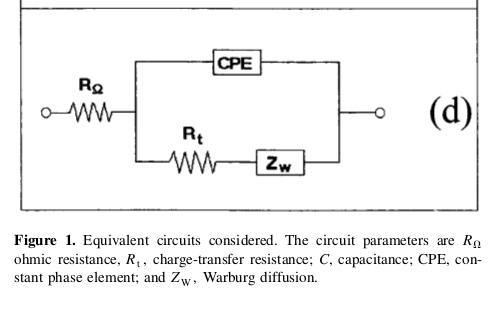

In [21]:
from IPython.display import Image
Image(filename="circuito-equivalente.png")

Experimentalmente, la idea es excitar el circuito con un pulso  de corriente de corta duración y determinar la evolución de la tensión en función del tiempo en bornes del circuito.
Con el pulso de excitación y la respuesta, alimentar algún método de identificación de parámetros de sistema (ej. cuadrados mínimos) para determinar: $R_{\omega}$, $R_{t}$, y $\beta$, $C_{cpe}$, $C_{w}$. 

$\frac {d u(t)^{\beta + 0.5}} {d t ^{\beta + 0.5}} + x_3 \frac {d u(t)^{\beta}} {d t ^{\beta}} + x_2 \frac {d u(t)^{0.5}} {d t ^{0.5}} = x_1 \frac {d i(t)^{0.5}} {d t ^{0.5}} + x_1 x_3 i(t)$

### IDEA: calcular con matríces.

La ecuación anterior sale de determinar la impedancia, del circuito mostrado. En este trabajo, en lugar de considerar la impedancia en bornes del circuito, considero la solución del circuito eléctrico aplicando la idea de que la suma de las corrientes en los nodos es cero. De ahí sale una matríz de admitancia y me permite obtener un sistema de ecuaciones diferenciales expresadas en forma discreta para resolver el circuito.

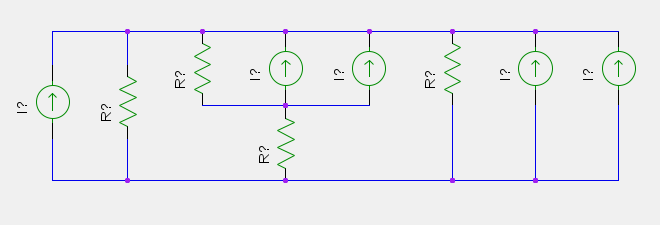

In [29]:
Image(filename="companinon.png")

## Operador derivada fraccional

$D^{\alpha} f(t) |_{t=kT} = \lim_{T \to 0} T^{-\alpha}\sum_{l=0}^{k} (-1)^{l} \binom{\alpha}{l}f[(k-l)T]  $

$ \binom{\alpha}{l} = \frac {\alpha (\alpha -1) ... (\alpha - l + 1)}{l!} $

#### Elimino el límite y saco de la sumatoria el elemento k-ésimo de la sumatoria 

Así queda que la derivada fraccional depende del valor actual de la función
y una sumatoria de términos que dependen de valores pasados de la función y el coeficiente binomial.

$\binom{\alpha}{0} = 1$

$D^{\alpha} f(t) |_{t=kT} = T^{-\alpha}(f[kT]) +\sum_{l=1}^{k} (-1)^{l} \binom{\alpha}{l}f[(k-l)T])  $

In [22]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
#
#  Ecuación que calcula los coeficientes binomiales
#
def binomial (alfa, N):
    b = np.zeros(0)
    b0 = 1
    b = np.append (b, b0)
    for i in range (1,N):
        b = np.append (b, (1 - (1+alfa)/i)*b[i-1])    
    return b

In [24]:
#
# Parámetros de la simulación
#
T = 0.001; I0 = 1e-5
Rt = 1000; Rg = 500; R0 = 1e7;
Alfa = 0.5; CAlfa = 1e-8; 
Beta = 0.9; CBeta = 1e-6; 
N = 1000

# Inicialización 
vn0 =  np.zeros (N)
vn1 =  np.zeros (N)
vn2 =  np.zeros (N)

ii = np.zeros(N)
ii [0:int(0.2*N)] = I0


# Cálculo de los parámetros constantes
Gt = 1/Rt; Gg = 1/Rg; G0 = 1/R0
CAlfa = np.power(CAlfa, Alfa); GAlfa = CAlfa*np.power(T, -Alfa)
CBeta = np.power(CBeta, Beta); GBeta = CBeta*np.power(T, -Beta)


# Cálculo de los binomiales
M = 100
qAlfa = binomial (Alfa, M)
qBeta = binomial (Beta, M)

# Determinación de la matríz de admitancia
admitancia = np.array ([
                        [G0+Gg, -Gg,               0], 
                        [Gg,    -(Gg+GBeta+GAlfa), GAlfa], 
                        [0,     GAlfa,             -(GAlfa+Gt)
                         ]])
# Cálculo de matriz de impedancia
impedancia = np.linalg.inv(admitancia)

print ("IMPEDANCIA", impedancia)    

IMPEDANCIA [[ 862.90072275 -362.94386778 -275.74548809]
 [ 362.94386778 -362.96201498 -275.75927537]
 [ 275.74548809 -275.75927537 -449.76033531]]


In [25]:
#
# Cálculo inicial de voltages de nodo
#
current = np.array([I0,0,0])
voltage = np.dot (impedancia, current)
vn0[0]  = voltage[0]
vn1[0]  = voltage[1]
vn2[0]  = voltage[2]

In [26]:
for k in range (1,N):
    vbeta = 0
    valfa = 0
    for l in range (1,k+1):
        if l < M:
            vbeta = vbeta + qBeta [l]*vn1[k-l]
            valfa = valfa + qAlfa [l]*(vn1[k-l] - vn2[k-l])
    current[0] = ii[k]
    current[1] = (GAlfa*valfa + GBeta*vbeta)
    current[2] = (-GAlfa*valfa)
    voltage = np.dot (impedancia, current)
    vn0[k] = voltage[0]
    vn1[k] = voltage[1]
    vn2[k] = voltage[2]

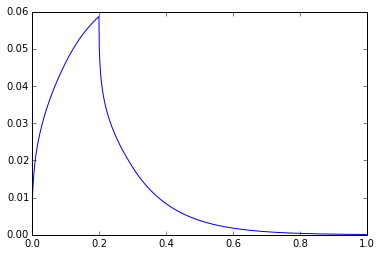

In [27]:
t = np.arange (N)*T
plt.plot(t,vn0)

In [28]:
vvn0= np.copy(vn0)

# Lo mismo usando clases

### Encapsular y reusar código.

In [8]:
class RandlesFrac(object):
    def __init__ (self, Ti, Ni, Rti, Rgi, R0i, Alfai, Calfai, Betai, Cbetai, I0i):
        self.T = Ti;   self.I0 = I0i
        self.Rt = Rti; self.Rg = Rgi; self.R0 = R0i
        self.Alfa = Alfai; self.CAlfa = Calfai
        self.Beta = Betai; self.CBeta = Cbetai
        self.N = Ni
        
        # Inicialización 
        self.vn0 =  np.zeros (self.N)
        self.vn1 =  np.zeros (self.N)
        self.vn2 =  np.zeros (self.N)
        
        self.ii = np.zeros(self.N)
        self.ii [0:int(0.2*self.N)] = self.I0

        # Cálculo de los parámetros constantes
        self.Gt = 1/self.Rt; self.Gg = 1/self.Rg; self.G0 = 1/self.R0
        self.CAlfa = np.power(self.CAlfa, self.Alfa)
        self.GAlfa = self.CAlfa*np.power(self.T, -self.Alfa)
        self.CBeta = np.power(self.CBeta, self.Beta)
        self.GBeta = self.CBeta*np.power(self.T, -self.Beta)

        # Cálculo de los binomiales
        self.M = 100
        self.qAlfa = self.binomial (self.Alfa, self.M)
        self.qBeta = self.binomial (self.Beta, self.M)
        
        # Cálculo de matriz de impedancia
        self.admitancia = np.array ([
                        [self.G0 + self.Gg, -self.Gg,                            0], 
                        [self.Gg, -(self.Gg + self.GBeta + self.GAlfa), self.GAlfa], 
                        [0,     self.GAlfa,             -(self.GAlfa + self.Gt)]
                         ])
        self.impedancia = np.linalg.inv(self.admitancia)
        
        
    #
    #  Ecuación que calcula los coeficientes binomiales
    #
    def binomial (self,alfa, N):
        b = np.zeros(0)
        b0 = 1
        b = np.append (b, b0)
        for i in range (1,N):
            b = np.append (b, (1 - (1+alfa)/i)*b[i-1])    
        return b

    def simulacion (self):
        print ("simulacion fraccional")
        #
        # Cálculo de voltages de nodo inicial
        #
        self.current = np.array ([self.I0,0,0])
        self.voltage = np.dot (self.impedancia, self.current)
        self.vn0[0]  = self.voltage[0]
        self.vn1[0]  = self.voltage[1]
        self.vn2[0]  = self.voltage[2]
        
        for k in range (1,self.N):
            vbeta = 0
            valfa = 0
            for l in range (1,k+1):
                if l < self.M:
                    vbeta = vbeta + self.qBeta [l]*self.vn1 [k-l]
                    valfa = valfa + self.qAlfa [l]*(self.vn1 [k-l] - self.vn2[k-l])
            self.current[0] = self.ii[k]
            self.current[1] = (self.GAlfa*valfa + self.GBeta*vbeta)
            self.current[2] = (-self.GAlfa*valfa)
            self.voltage = np.dot (self.impedancia, self.current)
            self.vn0[k] = self.voltage[0]
            self.vn1[k] = self.voltage[1]
            self.vn2[k] = self.voltage[2]

In [9]:
T = 0.001; N = 1000; I0 = 1e-5; R0 = 1e7; alfa = .5
t = np.arange (N)*T
#
#                  Ti, Ni, Rti, Rgi, R0i, Alfai, Calfai, Betai, Cbetai, I0i
#
randles1 = RandlesFrac(T, N, 1000, 5000, R0, alfa, 1e-8, .9, 1e-6, I0)
randles2 = RandlesFrac(T, N, 1000, 5000, R0, alfa, 1e-8, .8, 1e-6, I0)
randles3 = RandlesFrac(T, N, 1000, 5000, R0, alfa, 1e-8, .7, 1e-6, I0)

In [10]:
randles1.simulacion()
randles2.simulacion()
randles3.simulacion()

simulacion fraccional
simulacion fraccional
simulacion fraccional


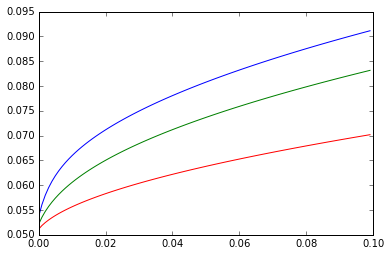

In [11]:
plt.plot(t[0:100],randles1.vn0[0:100])
plt.plot(t[0:100],randles2.vn0[0:100])
plt.plot(t[0:100],randles3.vn0[0:100])


In [12]:
#
#                  Ti, Ni, Rti, Rgi, R0i, Alfai, Calfai, Betai, Cbetai, I0i
#
randles4 = RandlesFrac(T, N, 100, 5000, R0, alfa, 1e-8, .6, 1e-6, I0)
randles5 = RandlesFrac(T, N, 1000, 5000, R0, alfa, 1e-8, .6, 1e-6, I0)
randles6 = RandlesFrac(T, N, 10000, 5000, R0, alfa, 1e-8, .6, 1e-6, I0)

In [13]:
randles4.simulacion()
randles5.simulacion()
randles6.simulacion()

simulacion fraccional
simulacion fraccional
simulacion fraccional


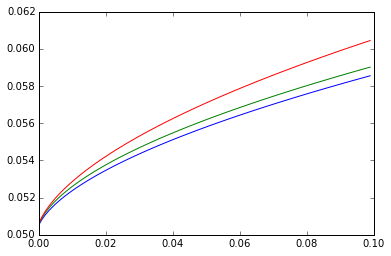

In [119]:
plt.plot(t[0:100],randles4.vn0[0:100])
plt.plot(t[0:100],randles5.vn0[0:100])
plt.plot(t[0:100],randles6.vn0[0:100])

In [179]:
class RandlesIdeal (RandlesFrac):
    
    def __init__ (self, Ti, Ni, Rti, Rgi, R0i, Calfai, Cbetai, I0i):
        
        self.T = Ti; self.I0 = I0i       
        self.Rt = Rti; self.Rg = Rgi; self.R0 = R0i
        self.CAlfa = Calfai
        self.CBeta = Cbetai
        self.N = Ni
        
        # Inicialización 
        self.vn0 =  np.zeros (self.N)
        self.vn1 =  np.zeros (self.N)
        self.vn2 =  np.zeros (self.N)
        
        self.ii = np.zeros(self.N)
        self.ii [0:int(0.2*self.N)] = self.I0

        # Cálculo de los parámetros constantes
        self.Gt = 1/self.Rt; self.Gg = 1/self.Rg; self.G0 = 1/self.R0
         
        self.GAlfa = self.CAlfa/self.T
         
        self.GBeta = self.CBeta/self.T

        # Cálculo de matriz de impedancia
        self.admitancia = np.array ([[self.G0 + self.Gg, -self.Gg,               0], 
                        [self.Gg, -(self.Gg + self.GBeta + self.GAlfa), self.GAlfa], 
                        [0,     self.GAlfa,             -(self.GAlfa + self.Gt)]])
        self.impedancia = np.linalg.inv(self.admitancia)    
        
    def simulacion (self):
        print ("simulacion ideal")
        #
        # Cálculo de voltages de nodo inicial
        #
        self.current = np.array ([self.I0,0,0])
        self.voltage = np.dot (self.impedancia, self.current)
        self.vn0[0]  = self.voltage[0]
        self.vn1[0]  = self.voltage[1]
        self.vn2[0]  = self.voltage[2]
    
        for k in range (1,self.N):
            
            ialfa = self.GAlfa * (self.vn1[k-1] - self.vn2[k-1])
            ibeta = self.GBeta * self.vn1[k-1]
            
            
            self.current[0] = self.ii[k]
            self.current[1] = -(ialfa + ibeta ) #-(self.GAlfa*valfa + self.GBeta*vbeta)
            self.current[2] = ialfa #(self.GAlfa*valfa)
            self.voltage = np.dot (self.impedancia, self.current)
            self.vn0[k] = self.voltage[0]
            self.vn1[k] = self.voltage[1]
            self.vn2[k] = self.voltage[2]

In [267]:
# Ti, Ni, Rti, Rgi, R0i, Calfai, Cbetai, I0i
T = 1e-4; N = int(1e4)
randles11 = RandlesIdeal(T, N, 10000, 5000, R0,      1e-4,      1e-5, I0)
randles6 =  RandlesFrac (T, N, 10000, 5000, R0, .50, 1e-4, .95, 1e-5, I0) 

In [268]:
randles11.simulacion()
randles6.simulacion()

simulacion ideal


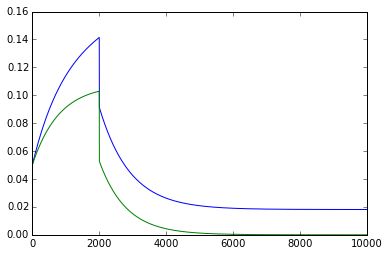

In [269]:
plt.plot(randles11.vn0)
plt.plot(randles6.vn0)

simulacion ideal


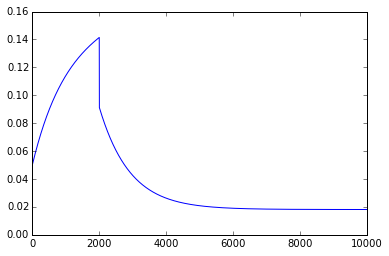

In [263]:
# Ti, Ni, Rti, Rgi, R0i, Calfai, Cbetai, I0i
T = 1e-4; N = int(1e4)
randles11 = RandlesIdeal(T, N, 10000, 5000, R0,      1e-4,      1e-5, I0)
randles11.simulacion()
plt.plot(randles11.vn0)